# Loading and Cleaning Datasets

In [1]:
import pandas as pd
import numpy as np
import spacy as sp
import re
import os
import transformers
import torch
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


import torch.nn as nn
from torch import cuda
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification, AutoTokenizer



import warnings
warnings.filterwarnings('ignore')

### Config

In [29]:
class Config():
    def __init__(self, platform, model_name, pretrained_model_name):
        # platform = 'Kaggle'# 
        if platform == 'Kaggle':
            pretrained_model = '../input/huggingface-bert/' + pretrained_model_name + '/'
            train_path = 'path_TBD/train.json'
            # test_path = ''
            model_path = 'path_TBD/' + model_name
        elif platform == 'local':
            model_path = '../models/bert_models/' + model_name
        
        self.config = {
            'MAX_LEN': 128,
            'TRAIN_BATCH_SIZE': 4,
            'VALID_BATCH_SIZE': 2,
            'EPOCHS': 1,
            'LEARNING_RATE':1e-5,
            'MAX_GRAD_NORM': 10,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            # 'device': 'cpu',
            'model_path': model_path,
            'pretrained_model': pretrained_model_name,
            'tokenizer': BertTokenizerFast.from_pretrained(pretrained_model_name)
        }

In [30]:
platform = 'local'
pretrainend_model_name = 'bert-large-cased'
model_num = 1
model_name = 'model' + str(model_num) + '_' + pretrainend_model_name +'.bin'

config = Config(platform,model_name, pretrainend_model_name).config

Requires:
```git lfs track "*.safetensors"```
to clone model from github

If using IDE, Run 
```
python -m spacy download en_core_web_sm
```
in the bash to install the english spacy pipline

## Official Datasets

### Data and Exploration

In [31]:
df = pd.read_json("../Datasets/Official/train.json")
df

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...,...
6802,22678,EXAMPLE – JOURNEY MAP\n\nTHE CHALLENGE My w...,"[EXAMPLE, –, JOURNEY, MAP, \n\n, THE, CHALLENG...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,Why Mind Mapping?\n\nMind maps are graphical r...,"[Why, Mind, Mapping, ?, \n\n, Mind, maps, are,...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"Challenge\n\nSo, a few months back, I had chos...","[Challenge, \n\n, So, ,, a, few, months, back,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,Brainstorming\n\nChallenge & Selection\n\nBrai...,"[Brainstorming, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [5]:
# df[df.isnull().any(axis = 1)]

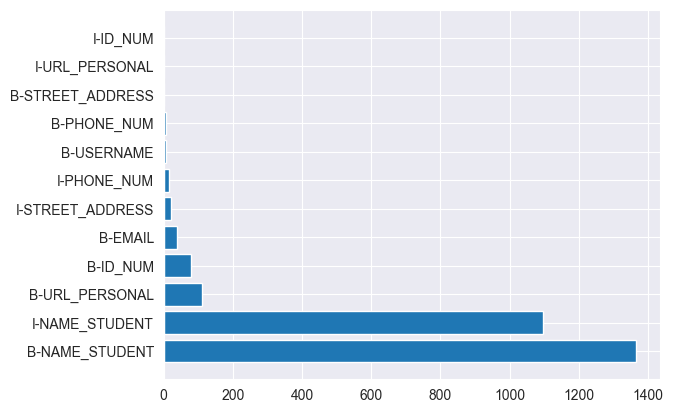

In [32]:
from collections import Counter
c = Counter()
df.apply(lambda line: c.update(line.labels), axis = 1)
c_pii = c.most_common()[1:]
c_key, c_val = zip(*c_pii)
plt.barh(c_key, c_val)
plt.show()

In [7]:
c_pii

[('B-NAME_STUDENT', 1365),
 ('I-NAME_STUDENT', 1096),
 ('B-URL_PERSONAL', 110),
 ('B-ID_NUM', 78),
 ('B-EMAIL', 39),
 ('I-STREET_ADDRESS', 20),
 ('I-PHONE_NUM', 15),
 ('B-USERNAME', 6),
 ('B-PHONE_NUM', 6),
 ('B-STREET_ADDRESS', 2),
 ('I-URL_PERSONAL', 1),
 ('I-ID_NUM', 1)]

In [38]:
labels_to_ids = {k: v for v, k in enumerate(c.keys())}
ids_to_labels = {v: k for v, k in enumerate(c.keys())}
labels_to_ids

{'O': 0,
 'B-NAME_STUDENT': 1,
 'I-NAME_STUDENT': 2,
 'B-URL_PERSONAL': 3,
 'B-EMAIL': 4,
 'B-ID_NUM': 5,
 'I-URL_PERSONAL': 6,
 'B-USERNAME': 7,
 'B-PHONE_NUM': 8,
 'I-PHONE_NUM': 9,
 'B-STREET_ADDRESS': 10,
 'I-STREET_ADDRESS': 11,
 'I-ID_NUM': 12}

Can look at distribution of position of each PII; use counter as frequency table and plot hist

In [ ]:
c2 = Counter()
df.apply(lambda line: c.update(line.labels), axis = 1)

In [8]:
# entities_to_remove = ["I-ID_NUM", "I-URL_Personal", "B-STREET_ADDRESS", "B-PHONE_NUM", "B-USERNAME"]
# data = data[~data.Tag.isin(entities_to_remove)]
# data.head()

figure how to do without tokenizer

In [109]:
# token_counts = []
# for _, row in df_train.iterrows():
#     token_count = len(tokenizer.encode(
#         row["full_text"],
#         max_length=2048,
#         truncation=True
#     ))
#     token_counts.append(token_count)
# sns.histplot(token_counts)
# # plt.xlim([0, 512]);

### Preprocessing

In [20]:
df_usable = df.iloc[df[~(df.tokens.apply(len) != df.labels.apply(len))].index]
1-(len(df_usable.index))/len(df.index)

0.06184809754664311

In [21]:
pattern = re.compile('\xa0|\uf0b7|\u200b')
df_usable.loc[:,'full_text'] = df_usable.loc[:,'full_text'].replace(pattern, ' ')
df_usable.loc[:,'tokens'] = df_usable.loc[:,'tokens'].apply(lambda line: [tok for tok in line if not re.search(pattern,tok)])

In [16]:
df_usable

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
6,93,Silvia Villalobos\n\nChallenge:\n\nThere is a ...,"[Silvia, Villalobos, \n\n, Challenge, :, \n\n,...","[True, False, False, False, False, False, True...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
...,...,...,...,...,...
6802,22678,EXAMPLE – JOURNEY MAP\n\nTHE CHALLENGE My w...,"[EXAMPLE, –, JOURNEY, MAP, \n\n, THE, CHALLENG...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,Why Mind Mapping?\n\nMind maps are graphical r...,"[Why, Mind, Mapping, ?, \n\n, Mind, maps, are,...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"Challenge\n\nSo, a few months back, I had chos...","[Challenge, \n\n, So, ,, a, few, months, back,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,Brainstorming\n\nChallenge & Selection\n\nBrai...,"[Brainstorming, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [18]:
df

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, Visualization, Reflection, Sub...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...,...
6802,22678,EXAMPLE – JOURNEY MAP\n\nTHE CHALLENGE My w...,"[EXAMPLE, –, JOURNEY, MAP, \n\n, THE, CHALLENG...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,Why Mind Mapping?\n\nMind maps are graphical r...,"[Why, Mind, Mapping, ?, \n\n, Mind, maps, are,...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"Challenge\n\nSo, a few months back, I had chos...","[Challenge, \n\n, So, ,, a, few, months, back,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,Brainstorming\n\nChallenge & Selection\n\nBrai...,"[Brainstorming, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [111]:
# def labelling(line):
#     line_labels = pd.Series(line.labels)
#     labels_index = line_labels[line_labels != 'O'].index
#     return {index: (line_labels.loc[index], pd.Series(line.tokens).loc[index]) for index in labels_index.to_list()}
# 
# df_usable.loc[:,'label_dict'] = df_usable.apply(lambda line: labelling(line), axis = 1)
# df_usable

extremely low efficiency (ask for help) not usable/ buggy

In [112]:
# def make_shorter_sentence(line):
#     '''
#     This function is to split the essays into chunks of shorter sentences upto the 
#     maximum length of words specified in config['MAX_LEN'] The max has not yet been implemented
#     '''
#     tokens = line.tokens
#     labels = line.labels
# 
#     break_idx = 0    
#     sentences_per_phrase = 1
#     pattern = re.compile("^\.|\?|!$")
#     overlap = 2
#     final_sentences = []
#     
#     while break_idx < len(tokens) - 1:
#         period_count = 0
#         temp = break_idx
#         delta = break_idx - temp 
#         for tok in tokens[break_idx:]:
#             if period_count > sentences_per_phrase and delta < config['MAX_LEN']:
#                 period_count = 0
#                 break
#     
#             if re.search(pattern,tok):
#                 period_count += 1
#                 # print(period_count)
#             else:
#                 break_idx += 1
# 
#         final_sentences.append(tokens[temp:break_idx + overlap])
#     return final_sentences

## DO NOT UNCOMMENT, BUGGY
# df_usable.loc[:,'sentence_list'] = df_usable.apply(lambda line: make_shorter_sentence(line), axis = 1)
#
# items = range(150,200)
# exclude_list = [57,158]
# for idx in items:
#     if idx not in exclude_list:
#         print(idx)
#         df_usable.iloc[idx:idx+1].apply(lambda line: make_shorter_sentence(line), axis = 1)
# 
# make_shorter_sentence(df_usable.iloc[157])

In [35]:
def make_smaller_inputs(dataframe):
    df_out = pd.DataFrame(columns = ['tokens','labels'])
    counter = 0
    max_len = config['MAX_LEN']
    
    for _,line in dataframe.iterrows():
        tokens = line.tokens
        labels = line.labels
        items = range(0,len(tokens),max_len)
        
        for i in items:
            df_out.at[counter,'tokens'] = tokens[i:i+max_len]
            df_out.at[counter,'labels'] = labels[i:i+max_len]
            counter += 1
            
    return df_out

In [36]:
df_model_input = make_smaller_inputs(df_usable)
df_model_input.head()

,tokens,labels
0,"[Design, Thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,"[significant, material, investment, and, can, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[starting, point, , generates, ideas, /, work...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[the, series, , of, questions, according, to,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[images, and, interconnections, ., This, secon...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [37]:
len(df_model_input.index)

39146

In [116]:
df_train, df_test = train_test_split(df_model_input, test_size=0.2)

In [117]:
df_train.reset_index(drop = True, inplace=True)
df_train

,tokens,labels
0,"[discipline, ,, loyalty, ,, leadership, , and...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[these, special, reagions, to, 15, ., \n\n, We...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[be, happy, to, answer, to, surveys, on, a, we...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[are, created, in, formats, that, are, interpr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[a, review, or, a, new, batch, of, training, p...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...
7995,"[ , affected, humanitarian, crisis, such, as, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7996,"[to, be, a, great, tool, for, getting, people,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
7997,"[new, , aggressive, and, rapid, use, of, our,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7998,"[), \n\n, Insight, :, Describe, the, insight, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [118]:
df_test.reset_index(drop = True, inplace=True)
df_test

,tokens,labels
0,"[., This, exercise, follows, a, branch, format...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[In, highly, technology, and, global, competit...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[and, resulting, customer, centricity, ., \n\n...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[issues, ,, trying, to, be, very, visual, and,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[years, ,, probably, we, will, go, straight, t...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...
1995,"[,, raising, concerns, that, they, are, not, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1996,"[information, from, the, expert, like, IT, ,, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1997,"[I, participate, ., \n\n]","[O, O, O, O]"
1998,"[map, is, intended, to, serve, as, a, bridge, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


# Model


adapted from 
https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Custom_Named_Entity_Recognition_with_BERT_only_first_wordpiece.ipynb#scrollTo=Eh3ckSO0YMZW

In [119]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        tokens = self.data.tokens[index]
        word_labels = self.data.labels[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(tokens,
                                  is_split_into_words=True,
                                  return_offsets_mapping=True,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [ labels_to_ids[label] for label in word_labels]
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] == 0 and mapping[1] != 0:
                # overwrite label
                encoded_labels[idx] = labels[i]
                i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

    def __len__(self):
        return self.len

In [120]:
training_set = dataset(df_train, config['tokenizer'], config['MAX_LEN'])
testing_set = dataset(df_test, config['tokenizer'], config['MAX_LEN'])

In [121]:
training_set[2]["input_ids"].unsqueeze(0)

tensor([[  101,  1129,  2816,  1106,  2590,  1106, 13634,  1113,   170,  5392,
          3142,   119,   138,  5980,  1110,   170,  1141,   118,  1236,  4909,
          1229,  9681,  4286,  1110,  1304, 12196,   117,  2368,  1366,  1103,
          2000,  1105,  1159,  1106,  2437,  1120,   170,  6353,  1634,  1103,
         13032,  1195,  1460,   119,  1573,  1195,  1354,  1115,  9681,  4286,
          1110,  1103,  1211,  5806,  6806,  1106,  1329,  1120,  1115,  2585,
          1104,  1103,  1933,   119,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [122]:
for token, label in zip(config['tokenizer'].convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
    print('{0:10}  {1}'.format(token, label))

[CLS]       -100
discipline  0
,           0
loyalty     0
,           0
leadership  0
and         0
creativity  0
under       0
severe      0
c           0
##ir        -100
##cu        -100
##nst       -100
##ance      -100
##s         -100
.           0
I           0
noted       0
that        0
my          0
colleagues  0
listened    0
the         0
story       0
with        0
great       0
interest    0
and         0
wonder      0
.           0
After       0
that        0
,           0
they        0
demonstrate  0
much        0
more        0
interest    0
and         0
spirit      0
of          0
cooperation  0
.           0
In          0
##sight     -100
&           0
A           0
##pp        -100
##roach     -100
For         0
me          0
,           0
storytelling  0
is          0
an          0
ex          0
##cel       -100
##ent       -100
tool        0
to          0
cone        0
##ct        -100
people      0
to          0
certain     0
ideas       0
and         0
values  

In [123]:
train_params = {'batch_size': config["TRAIN_BATCH_SIZE"],
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': config["VALID_BATCH_SIZE"],
               'shuffle': True,
               'num_workers': 0
               }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [124]:
model = BertForTokenClassification.from_pretrained(config['pretrained_model'], num_labels=len(labels_to_ids))
model.to(config['device'])

KeyError: 'pretrained_model'

expected loss of inital model is 
-ln(1/(# of classes))

In [ ]:
-np.log(1/len(labels_to_ids))

In [ ]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(config['device'])
attention_mask = attention_mask.to(config['device'])
labels = labels.to(config['device'])

outputs = model(input_ids.long(), attention_mask=attention_mask.long(), labels=labels.long())
initial_loss = outputs[0]
initial_loss

Limit of my comprehension as of 3/7

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['LEARNING_RATE'])

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['input_ids'].to(config['device'], dtype = torch.long)
        mask = batch['attention_mask'].to(config['device'], dtype = torch.long)
        labels = batch['labels'].to(config['device'], dtype = torch.long)

        outputs = model(input_ids=ids.long(), attention_mask=mask.long(), labels=labels.long())
        loss = outputs[0]
        tr_logits = outputs[1]
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=config['MAX_GRAD_NORM']
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

### Determine whether to run training

In [ ]:
run = False

In [ ]:
if run:
    for epoch in range(config['EPOCHS']):
        print(f"Training epoch: {epoch + 1}")
        train(epoch)
    run = False

KeyError: 9637
KeyError: 2326
KeyError: 10126

Training epoch: 1
Training loss per 100 training steps: 2.7618727684020996
Training loss per 100 training steps: 0.16489562393272167
Training loss per 100 training steps: 0.08506841691869974
Training loss per 100 training steps: 0.05866454021836572
Training loss per 100 training steps: 0.0448566305917337
Training loss per 100 training steps: 0.03700114993198204
Training loss per 100 training steps: 0.03148505321677023
Training loss per 100 training steps: 0.027487104761941668
Training loss per 100 training steps: 0.02472412176731074
Training loss per 100 training steps: 0.022315634308862485
Training loss per 100 training steps: 0.020358747662810657
Training loss per 100 training steps: 0.018798588405868257
Training loss per 100 training steps: 0.01771995336807788
Training loss per 100 training steps: 0.016532918837726875
Training loss per 100 training steps: 0.01559861331037873
Training loss per 100 training steps: 0.014847838147105554
Training loss per 100 training steps: 0.014085038305332555
Training loss per 100 training steps: 0.01341761080099804
Training loss per 100 training steps: 0.012970763410538278
Training loss per 100 training steps: 0.01238988842706385
Training loss per 100 training steps: 0.011946241673651273
Training loss per 100 training steps: 0.011436048718409393
Training loss per 100 training steps: 0.01119401791093853
Training loss per 100 training steps: 0.01077323481422868
Training loss per 100 training steps: 0.010417857425509335
Training loss per 100 training steps: 0.010077849820839403
Training loss per 100 training steps: 0.009746479573238202
Training loss per 100 training steps: 0.009407942358349542
Training loss per 100 training steps: 0.00914617103634552
Training loss per 100 training steps: 0.008907846019452265
Training loss per 100 training steps: 0.008657838686139311
Training loss per 100 training steps: 0.008449268298699422
Training loss per 100 training steps: 0.008295341608228847
Training loss per 100 training steps: 0.008189213672816328
Training loss per 100 training steps: 0.007978749200488505
Training loss per 100 training steps: 0.007829300027857769
Training loss per 100 training steps: 0.0077915255697598535
Training loss per 100 training steps: 0.007615185001152273
Training loss per 100 training steps: 0.007460967634521881
Training loss per 100 training steps: 0.0073240728916386
Training loss epoch: 0.007183262327166176
Training accuracy epoch: 0.9988009906964034

Execution Time: 2h 33m 45s
Batch Size: 2
LR: 1e-5
Optimizer: Adam

In [ ]:
import os

directory = config['model_path']

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
config['tokenizer'].save_vocabulary(directory)
# save the model weights and its configuration file
save_model = False
if save_model:  
    model.save_pretrained(directory)
    print('All files saved')

In [ ]:
model = BertForTokenClassification.from_pretrained(config['model_path'], num_labels=len(labels_to_ids))
model1.to(config['device'])

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(config['device'], dtype = torch.long)
            mask = batch['attention_mask'].to(config['device'], dtype = torch.long)
            labels = batch['labels'].to(config['device'], dtype = torch.long)

            outputs = model(input_ids=ids.long(), attention_mask=mask.long(), labels=labels.long())
            
            loss = outputs[0]
            eval_logits = outputs[1]
            eval_loss += loss.item()
            
            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
            
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels, predictions = valid(model1, testing_loader)

Validation loss per 100 evaluation steps: 4.3060306779807433e-05
Validation loss per 100 evaluation steps: 0.0003900290700612189
Validation loss per 100 evaluation steps: 0.0008872096701063255
Validation loss per 100 evaluation steps: 0.0017595441007012122
Validation loss per 100 evaluation steps: 0.001834294180439077
Validation loss per 100 evaluation steps: 0.002054755131990794
Validation loss per 100 evaluation steps: 0.0022841157073565164
Validation loss per 100 evaluation steps: 0.0023434926568139487
Validation loss per 100 evaluation steps: 0.0024022069384918767
Validation loss per 100 evaluation steps: 0.0026039667075087917
Validation Loss: 0.0025191350434306515
Validation Accuracy: 0.9994422838479019
Execution Time: 08m 07.238s

In [ ]:
print(classification_report(labels, predictions))

About 50% for getting student names correct, 0% for the others